# ACF & PACF

## Overview

```python
p, d, q = 1, 1, 3  # Non-seasonal parameters
P, D, Q, s = 1, 0, 3, 12  # Seasonal parameters

order = (p, d, q)
seasonal_order = (P, D, Q, s)

model = SARIMAX(series, order=order, seasonal_order=seasonal_order)
```

In [25]:
from statsmodels.tsa.arima.model import ARIMA 
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [26]:
ARIMA

statsmodels.tsa.arima.model.ARIMA

In [27]:
SARIMAX

statsmodels.tsa.statespace.sarimax.SARIMAX

<style>
    table.custom-table {
        max-width: 1000px;
        width: 100%;
        margin: 0 auto; /* centers the table on the page */
    }

    table.custom-table td {
        background-color: #fff;
    }
    
    table.custom-table th, table.custom-table td {
        text-align: center;
        vertical-align: middle;
        padding: 5px;
        width: 500px; /* distribute the total width equally among three columns */
    }

    table.custom-table img {
        width: 100%;
        display: block; /* removes any gap under the image */
    }
</style>

<table class="custom-table">
    <thead>
        <tr>
            <th>ARIMA Model Parameters</th>
            <th>SARIMA Model Parameters</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>
                <table>
                    <tr><th>Parameter</th><th>Abbreviation</th><th>Description</th><th>Correlation Plot Type</th></tr>
                    <tr><td>p</td><td>AR</td><td>Auto Regression Order</td><td>Partial Autocorrelation</td></tr>
                    <tr><td>d</td><td>-</td><td>Differencing Order</td><td>-</td></tr>
                    <tr><td>q</td><td>MA</td><td>Moving Average Order</td><td>Autocorrelation</td></tr>
                </table>
            </td>
            <td>
                <table>
                    <tr><th>Parameter</th><th>Abbreviation</th><th>Description</th><th>Correlation Plot Type</th></tr>
                    <tr><td>p</td><td>AR</td><td>Auto Regression Order</td><td>Partial Autocorrelation</td></tr>
                    <tr><td>d</td><td>-</td><td>Differencing Order</td><td>-</td></tr>
                    <tr><td>q</td><td>MA</td><td>Moving Average Order</td><td>Autocorrelation</td></tr>
                    <tr><td>P</td><td>SAR</td><td>Seasonal Auto Regression Order</td><td>Partial Autocorrelation</td></tr>
                    <tr><td>D</td><td>-</td><td>Seasonal Differencing Order</td><td>-</td></tr>
                    <tr><td>Q</td><td>SMA</td><td>Seasonal Moving Average Order</td><td>Autocorrelation</td></tr>
                    <tr><td>s</td><td>-</td><td>Seasonal Period (in time units)</td><td>-</td></tr>
                </table>
            </td>
        </tr>
    </tbody>
</table>

![](src/03_input.png)

In [1]:
import warnings 
warnings.filterwarnings('ignore')

## Data

In [66]:
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt

pd.options.plotting.backend = 'plotly'

df_passengers = pd.read_csv('../data/airline-passengers.csv', parse_dates=["Month"], index_col="Month")
df_passengers = df_passengers.asfreq('MS')
series = df_passengers.Passengers
series

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
             ... 
1960-08-01    606
1960-09-01    508
1960-10-01    461
1960-11-01    390
1960-12-01    432
Freq: MS, Name: Passengers, Length: 144, dtype: int64

## Check Stationarity & Seasonality

In [4]:
series.plot(width=800)

A simple vista se ve estacionalidad, pero vamos a analizarlo con el test de adfuller

In [5]:
from statsmodels.tsa.stattools import adfuller

adfuller(series)

(np.float64(0.8153688792060482),
 np.float64(0.991880243437641),
 13,
 130,
 {'1%': np.float64(-3.4816817173418295),
  '5%': np.float64(-2.8840418343195267),
  '10%': np.float64(-2.578770059171598)},
 np.float64(996.692930839019))

Como el p_valor es mayor que 0.05, no podemos rechazar la hipótesis nula de que la serie temporal no es estacionaria. Por tanto, vamos a diferenciar.

In [67]:
series_dt1 = series.diff().dropna()
series_dt1.plot(width=800)

In [9]:
adfuller(series_dt1)

(np.float64(-2.8292668241699994),
 np.float64(0.0542132902838255),
 12,
 130,
 {'1%': np.float64(-3.4816817173418295),
  '5%': np.float64(-2.8840418343195267),
  '10%': np.float64(-2.578770059171598)},
 np.float64(988.5069317854084))

Como el p_valor sigue siendo mayor que 0,05, seguimos sin poder rechazar la hipótesis nula de que no existen componentes no estacionarios. Seguimos diferenciando.

In [68]:
series_dt1_ds12 = series_dt1.diff(12).dropna()
series_dt1_ds12.plot(width=800)

In [13]:
adfuller(series_dt1_ds12)

(np.float64(-15.595618083746334),
 np.float64(1.8565116001234705e-28),
 0,
 130,
 {'1%': np.float64(-3.4816817173418295),
  '5%': np.float64(-2.8840418343195267),
  '10%': np.float64(-2.578770059171598)},
 np.float64(919.8428088960275))

El p_valor ya es inferior a 0,05, por lo que podemos aceptar la hipótesis nula de que la serie es estacionaria. 

## ACF & PACF

In [16]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf

### ARIMA (p,d,q)

| Parameter | Abbreviation   | Description              | Correlation Plot Type  |
|-----------|----------------|--------------------------|------------------------|
| p         | AR | Auto Regression Order    | Partial Autocorrelation|
| d         | -              | Differencing Order       | -                      |
| q         | MA | Moving Average Order     | Autocorrelation        |

Al haber tenido que aplicar diferenciación, en el parámetro d vamos a aplicar un 1.

#### Partial Autocorrelation Plot for `p`

##### Calculation

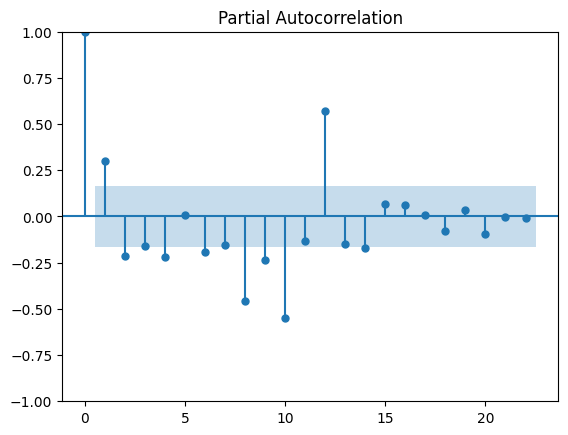

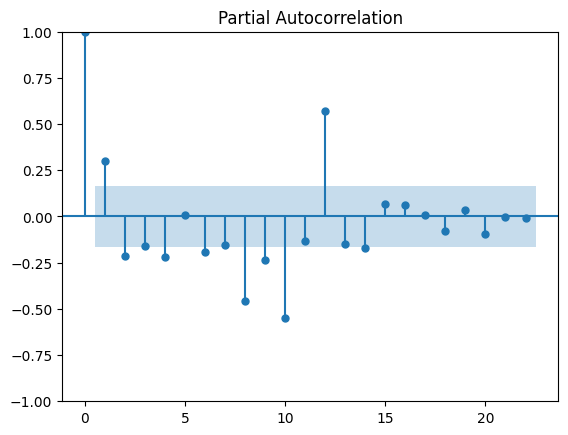

In [20]:
plot_pacf(series_dt1)

Seleccionamos las 2 primeras lags (obviando la primera), porque están por encima del intervalo azul

##### Model Application

```python
p = 2
d = 1 # differencing to make series stationary (ie, no trend)
q = ?

model = ARIMA(series, order=(p,d,q))
```

#### Autocorrelation Plot for `q`

##### Calculation

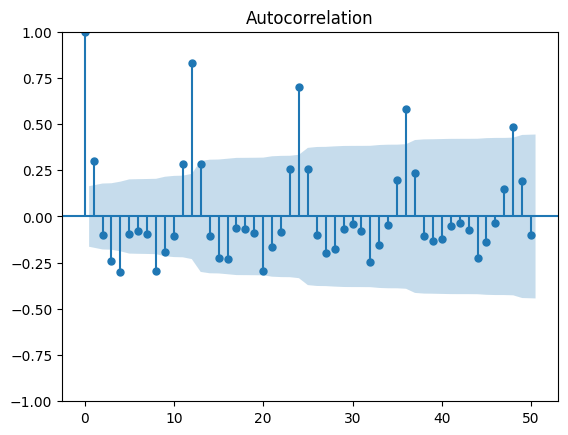

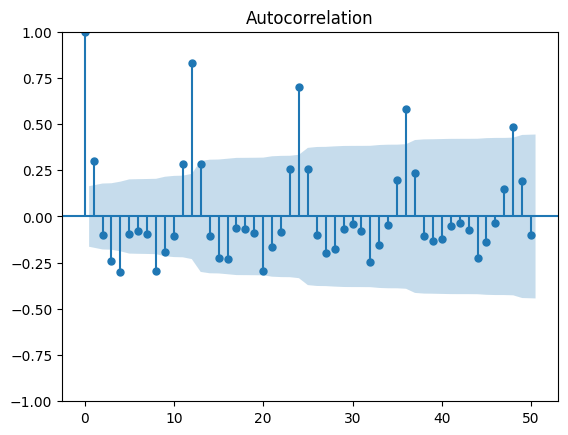

In [22]:
plot_acf(series_dt1, lags=50)

Utilizaremos un 1, (porque la 1 no cuenta, entonces es la 2)

##### Model Application

In [23]:
p = 2
d = 1
q = 1

order = (p,d,q)

In [28]:
model = ARIMA(series, order=order)
model_fit = model.fit()

#### Manual Tuning

##### Analize Forecast

In [29]:
horizon = 48
y_pred = model_fit.forecast(steps=horizon)
y_pred.head(5)

1961-01-01    471.000383
1961-02-01    492.998177
1961-03-01    497.918890
1961-04-01    492.528738
1961-05-01    484.243730
Freq: MS, Name: predicted_mean, dtype: float64

In [30]:
series.tail(5)

Month
1960-08-01    606
1960-09-01    508
1960-10-01    461
1960-11-01    390
1960-12-01    432
Freq: MS, Name: Passengers, dtype: int64

In [31]:
df_pred = series.to_frame()
df_pred

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


In [33]:
y_pred.name=f'Forecast {order}'
df_pred = pd.concat([df_pred, y_pred], axis=1)
df_pred

,Passengers,"Forecast (2, 1, 1)"
1949-01-01,112.0,NaN
1949-02-01,118.0,NaN
1949-03-01,132.0,NaN
1949-04-01,129.0,NaN
1949-05-01,121.0,NaN
...,...,...
1964-08-01,NaN,478.347157
1964-09-01,NaN,478.347156
1964-10-01,NaN,478.347159
1964-11-01,NaN,478.347161


In [34]:
df_pred.plot(width=800)

##### Compare with New Order

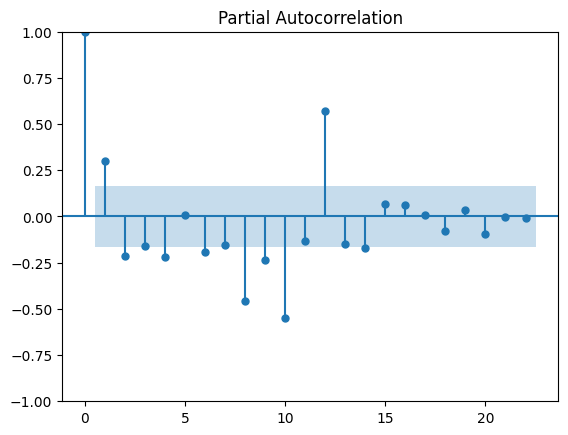

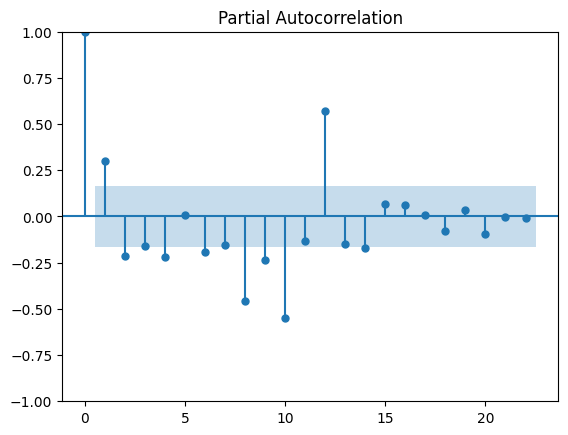

In [35]:
plot_pacf(series_dt1)

In [36]:
p = 12
d = 1
q = 1

order = (p,d,q)

model = ARIMA(series, order=order)
model_fit = model.fit()

c:\Users\RafaelAndreo_6gt1g09\OneDrive - BRUC ENERGY SL\Documentos\Formaciones\Analisis_modelado_sries_temporales\TS\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [37]:
horizon = 48
y_pred = model_fit.forecast(steps=horizon)
y_pred.name=f'Forecast {order}'

df_pred = pd.concat([df_pred, y_pred], axis=1)
df_pred

,Passengers,"Forecast (2, 1, 1)","Forecast (12, 1, 1)"
1949-01-01,112.0,NaN,NaN
1949-02-01,118.0,NaN,NaN
1949-03-01,132.0,NaN,NaN
1949-04-01,129.0,NaN,NaN
1949-05-01,121.0,NaN,NaN
...,...,...,...
1964-08-01,NaN,478.347157,651.551248
1964-09-01,NaN,478.347156,580.926584
1964-10-01,NaN,478.347159,520.528491
1964-11-01,NaN,478.347161,468.641433


In [38]:
df_pred.plot(width=800)

#### Comparing Different Numbers

In [39]:
def add_forecast_column(series, df_pred, horizon, order=(2,1,12)):
    model = ARIMA(series, order=order)
    model_fit = model.fit()
    y_pred = model_fit.forecast(steps=horizon)
    y_pred.name=f'Forecast {order}'
    df_pred = pd.concat([df_pred, y_pred], axis=1)
    return df_pred
                        

##### `P` for Moving Average [MA] with ACF

- ARIMA (P,d,Q)
- ARIMA (MA,d,AR)
- ARIMA (ACF,d,PACF)

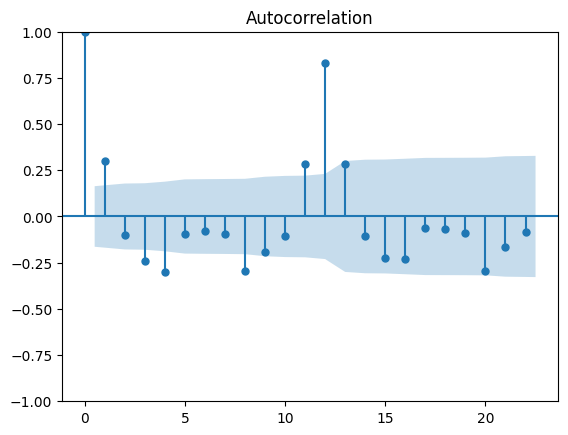

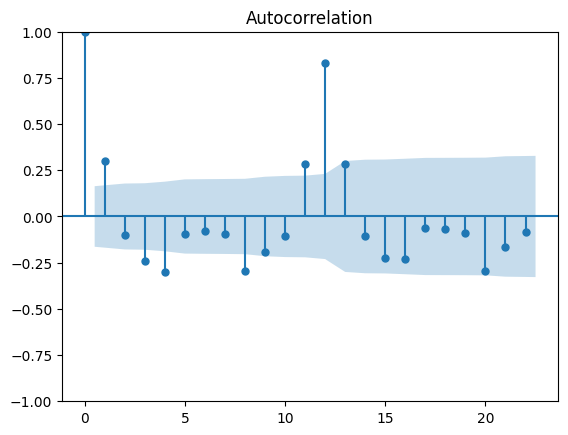

In [41]:
plot_acf(series_dt1)

In [40]:
df_pred = series.to_frame()

list_combo = {
    (12, 1, 1),
    (12, 1, 3),
    (12, 1, 4),
    (12, 1, 8),
    (12, 1, 11)
}

for combo in list_combo:
    df_pred = add_forecast_column(series, df_pred, horizon=48, order=combo)

df_pred

c:\Users\RafaelAndreo_6gt1g09\OneDrive - BRUC ENERGY SL\Documentos\Formaciones\Analisis_modelado_sries_temporales\TS\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\RafaelAndreo_6gt1g09\OneDrive - BRUC ENERGY SL\Documentos\Formaciones\Analisis_modelado_sries_temporales\TS\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\RafaelAndreo_6gt1g09\OneDrive - BRUC ENERGY SL\Documentos\Formaciones\Analisis_modelado_sries_temporales\TS\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\RafaelAndreo_6gt1g09\OneDrive - BRUC ENERGY SL\Documentos\Formaciones\Analisis_modelado_sries_temporales\TS\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelih

,Passengers,"Forecast (12, 1, 4)","Forecast (12, 1, 8)","Forecast (12, 1, 3)","Forecast (12, 1, 11)","Forecast (12, 1, 1)"
1949-01-01,112.0,NaN,NaN,NaN,NaN,NaN
1949-02-01,118.0,NaN,NaN,NaN,NaN,NaN
1949-03-01,132.0,NaN,NaN,NaN,NaN,NaN
1949-04-01,129.0,NaN,NaN,NaN,NaN,NaN
1949-05-01,121.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
1964-08-01,NaN,663.744574,691.830869,654.828897,680.154561,651.551248
1964-09-01,NaN,586.098126,610.702668,577.168348,599.178849,580.926584
1964-10-01,NaN,529.093610,553.493466,519.784752,542.020714,520.528491
1964-11-01,NaN,486.163026,510.371510,473.802642,499.394441,468.641433


In [42]:
df_pred.plot(width=800)

##### `Q` for Auto Regression [AR] with PACF

- ARIMA (P,d,Q)
- ARIMA (MA,d,AR)
- ARIMA (ACF,d,PACF)

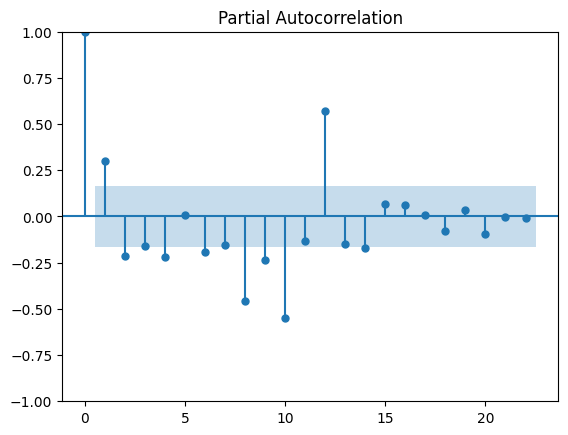

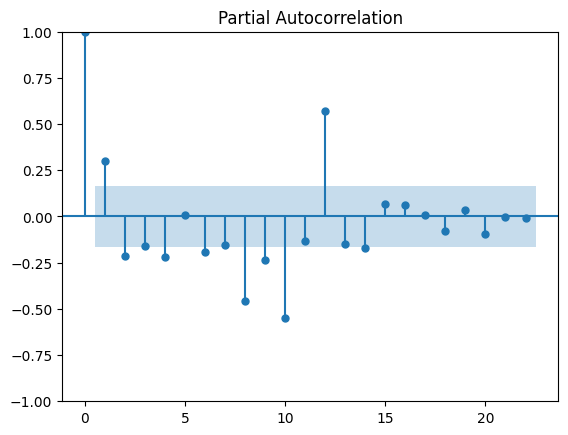

In [43]:
plot_pacf(series_dt1)

In [45]:
df_pred = series.to_frame()

list_combo = {
    (12, 1, 1),
    (1, 1, 1),
    (2, 1, 1),
    (3, 1, 1),
    (4, 1, 1),
    (8, 1, 1),
    (10, 1, 1)
}

for combo in list_combo:
    df_pred = add_forecast_column(series, df_pred, horizon=48, order=combo)

df_pred

c:\Users\RafaelAndreo_6gt1g09\OneDrive - BRUC ENERGY SL\Documentos\Formaciones\Analisis_modelado_sries_temporales\TS\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



,Passengers,"Forecast (2, 1, 1)","Forecast (8, 1, 1)","Forecast (1, 1, 1)","Forecast (10, 1, 1)","Forecast (4, 1, 1)","Forecast (3, 1, 1)","Forecast (12, 1, 1)"
1949-01-01,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1949-02-01,118.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1949-03-01,132.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1949-04-01,129.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1949-05-01,121.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
1964-08-01,NaN,478.347157,497.987583,461.66706,526.621212,480.858689,480.876879,651.551248
1964-09-01,NaN,478.347156,494.833105,461.66706,526.417278,480.858302,480.876805,580.926584
1964-10-01,NaN,478.347159,492.091336,461.66706,507.310448,480.858300,480.876825,520.528491
1964-11-01,NaN,478.347161,487.672352,461.66706,494.548962,480.858292,480.876889,468.641433


In [46]:
df_pred.plot(width=800)

### SARIMA (P,D,Q,s)

| Parameter | Abbreviation   | Description                     | Correlation Plot Type  |
|-----------|----------------|---------------------------------|------------------------|
| p         | AR | Auto Regression Order           | Partial Autocorrelation|
| d         | -              | Differencing Order              | -                      |
| q         | MA | Moving Average Order            | Autocorrelation        |
| P         | SAR | Seasonal Auto Regression Order   | Partial Autocorrelation|
| D         | -              | Seasonal Differencing Order     | -                      |
| Q         | SMA | Seasonal Moving Average Order   | Autocorrelation        |
| s         | -              | Seasonal Period (in time units) | -                      |

#### Manual Configuration

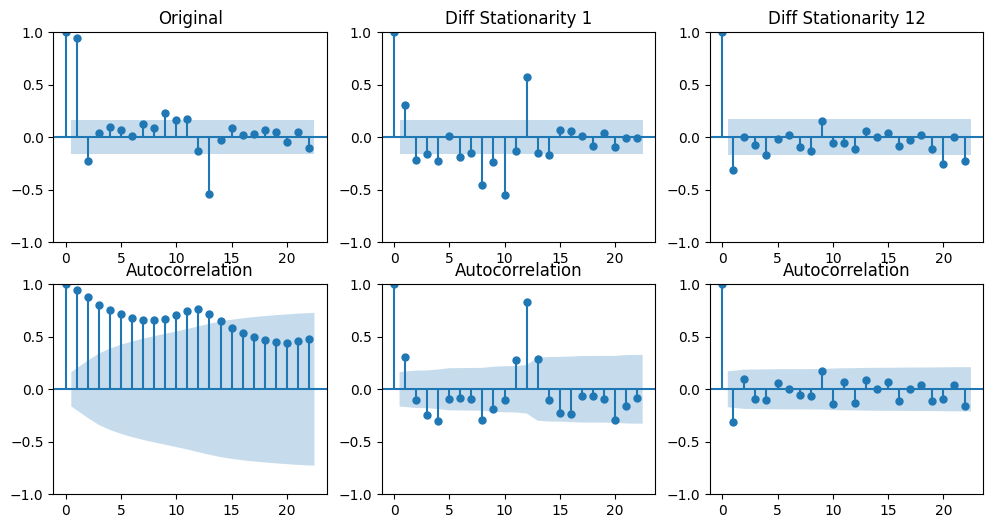

In [69]:
dict_series = {
    'Original': series,
    'Diff Stationarity 1': series_dt1,
    'Diff Stationarity 12': series_dt1_ds12
}

fig, axs = plt.subplots(2, 3, figsize=(12, 6))
for i, (name, s) in enumerate(dict_series.items()):
    plot_pacf(s, ax=axs[0, i])
    plot_acf(s, ax=axs[1, i])
    axs[0, i].set_title(name)


In [70]:
p, d, q = 2, 1, 1
P, D, Q, s = 1, 1, 1, 12

In [71]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

order = (p, d, q)
seasonal_order = (P, D, Q, s)

model = SARIMAX(series, order=order, seasonal_order=seasonal_order)
model_fit = model.fit(disp=False)

model_summary = model_fit.summary()
model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         Passengers   No. Observations:                  144
Model:             SARIMAX(2, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -503.124
Date:                            Tue, 05 Nov 2024   AIC                           1018.248
Time:                                    12:01:59   BIC                           1035.499
Sample:                                01-01-1949   HQIC                          1025.258
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5799      0.096      6.035      0.000       0.392       0.768
ar.L2          0.2287      0.103      2.211      0.027       0.026       0.431
ma.L1         -0.9782      0.043    -22.648      0.000      -1.063      -0.894
ar.S.L12      -0.9029      0.245     -3.693      0.000      -1.382      -0.424
ma.S.L12       0.8120      0.334      2.428      0.015       0.157       1.467
sigma2       124.4806     13.840      8.995      0.000      97.356     151.606
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                11.02
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               2.60   Skew:                             0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [72]:
df_pred = series.to_frame()
df_pred

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


In [73]:
horizon = 48
y_pred = model_fit.forecast(steps=horizon)
y_pred.name=f'Forecast {order} {seasonal_order}'

In [74]:
df_pred = pd.concat([df_pred, y_pred], axis=1)
df_pred

,Passengers,"Forecast (2, 1, 1) (1, 1, 1, 12)"
1949-01-01,112.0,NaN
1949-02-01,118.0,NaN
1949-03-01,132.0,NaN
1949-04-01,129.0,NaN
1949-05-01,121.0,NaN
...,...,...
1964-08-01,NaN,750.135227
1964-09-01,NaN,652.830229
1964-10-01,NaN,605.515848
1964-11-01,NaN,534.994965


In [75]:
df_pred.plot(width=800)

#### Grid Search

In [76]:
import pandas as pd
import statsmodels.tsa.statespace.sarimax as SARIMAX
import itertools

In [77]:
p = q = range(1, 5)
P = Q = range(1, 5)
d = D = range(2)
s = 12

In [78]:
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], s) for x in list(itertools.product(P, D, Q))]

In [79]:
pdq

[(1, 0, 1),
 (1, 0, 2),
 (1, 0, 3),
 (1, 0, 4),
 (1, 1, 1),
 (1, 1, 2),
 (1, 1, 3),
 (1, 1, 4),
 (2, 0, 1),
 (2, 0, 2),
 (2, 0, 3),
 (2, 0, 4),
 (2, 1, 1),
 (2, 1, 2),
 (2, 1, 3),
 (2, 1, 4),
 (3, 0, 1),
 (3, 0, 2),
 (3, 0, 3),
 (3, 0, 4),
 (3, 1, 1),
 (3, 1, 2),
 (3, 1, 3),
 (3, 1, 4),
 (4, 0, 1),
 (4, 0, 2),
 (4, 0, 3),
 (4, 0, 4),
 (4, 1, 1),
 (4, 1, 2),
 (4, 1, 3),
 (4, 1, 4)]

In [80]:
seasonal_pdq

[(1, 0, 1, 12),
 (1, 0, 2, 12),
 (1, 0, 3, 12),
 (1, 0, 4, 12),
 (1, 1, 1, 12),
 (1, 1, 2, 12),
 (1, 1, 3, 12),
 (1, 1, 4, 12),
 (2, 0, 1, 12),
 (2, 0, 2, 12),
 (2, 0, 3, 12),
 (2, 0, 4, 12),
 (2, 1, 1, 12),
 (2, 1, 2, 12),
 (2, 1, 3, 12),
 (2, 1, 4, 12),
 (3, 0, 1, 12),
 (3, 0, 2, 12),
 (3, 0, 3, 12),
 (3, 0, 4, 12),
 (3, 1, 1, 12),
 (3, 1, 2, 12),
 (3, 1, 3, 12),
 (3, 1, 4, 12),
 (4, 0, 1, 12),
 (4, 0, 2, 12),
 (4, 0, 3, 12),
 (4, 0, 4, 12),
 (4, 1, 1, 12),
 (4, 1, 2, 12),
 (4, 1, 3, 12),
 (4, 1, 4, 12)]

```python
from tqdm import tqdm_notebook

lowest_aic = float('inf')
best_pdq = best_seasonal_pdq = None

models = []

for param in tqdm_notebook(pdq):
    for param_seasonal in tqdm_notebook(seasonal_pdq):
        try:
            model = SARIMAX(series, order=param, seasonal_order=param_seasonal, enforce_stationarity=False, enforce_invertibility=False)
            results = model.fit(maxiter=10_000)
            models.append([model, results.aic, param, param_seasonal])
            if results.aic < lowest_aic:
                lowest_aic = results.aic
                best_pdq, best_seasonal_pdq = param, param_seasonal
        except:
            continue
```

In [ ]:
# Tarda horas
from tqdm import tqdm_notebook

lowest_aic = float('inf')
best_pdq = best_seasonal_pdq = None

models = []

for param in tqdm_notebook(pdq):
    for param_seasonal in tqdm_notebook(seasonal_pdq):
        try:
            model = SARIMAX(series, order=param, seasonal_order=param_seasonal, enforce_stationarity=False, enforce_invertibility=False)
            results = model.fit(maxiter=10_000)
            models.append([model, results.aic, param, param_seasonal])
            if results.aic < lowest_aic:
                lowest_aic = results.aic
                best_pdq, best_seasonal_pdq = param, param_seasonal
        except:
            continue

,AIC,order,order_seasonal
0,989.176474,"(1, 0, 1)","(1, 0, 1, 12)"
1,909.473501,"(1, 0, 1)","(1, 0, 2, 12)"
...,...,...,...
1022,32.000000,"(4, 1, 4)","(4, 1, 3, 12)"
1023,620.584467,"(4, 1, 4)","(4, 1, 4, 12)"


,AIC,order,order_seasonal
194,18.0,"(1, 1, 3)","(1, 0, 3, 12)"
550,20.0,"(3, 0, 2)","(1, 1, 3, 12)"
...,...,...,...
390,NaN,"(2, 1, 1)","(1, 1, 3, 12)"
414,NaN,"(2, 1, 1)","(4, 1, 3, 12)"


,AIC,order,order_seasonal
194,18.000000,"(1, 1, 3)","(1, 0, 3, 12)"
550,20.000000,"(3, 0, 2)","(1, 1, 3, 12)"
...,...,...,...
406,7374.579676,"(2, 1, 1)","(3, 1, 3, 12)"
398,7491.867681,"(2, 1, 1)","(2, 1, 3, 12)"


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         Passengers   No. Observations:                  144
Model:             SARIMAX(1, 1, 3)x(1, 0, 3, 12)   Log Likelihood                -562.676
Date:                            Thu, 30 May 2024   AIC                           1143.351
Time:                                    01:01:54   BIC                           1170.017
Sample:                                01-01-1949   HQIC                          1154.187
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7319      0.152      4.801      0.000       0.433       1.031
ma.L1         -1.0371      0.161     -6.423      0.000      -1.354      -0.721
ma.L2          0.2620      0.154      1.705      0.088      -0.039       0.563
ma.L3         -0.1733      0.123     -1.405      0.160      -0.415       0.069
ar.S.L12       0.9604      0.040     24.303      0.000       0.883       1.038
ma.S.L12      -0.1166      0.136     -0.856      0.392      -0.384       0.150
ma.S.L24       0.1051      0.131      0.803      0.422      -0.151       0.362
ma.S.L36      -0.0092      0.155     -0.059      0.953      -0.312       0.294
sigma2       124.3861     14.676      8.475      0.000      95.621     153.151
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):                32.64
Prob(Q):                              0.72   Prob(JB):                         0.00
Heteroskedasticity (H):               4.02   Skew:                             0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

,Passengers,"Forecast (2, 1, 1) (1, 1, 1, 12)","Forecast (1, 1, 3) (1, 0, 3, 12)"
1949-01-01,112.0,NaN,NaN
1949-02-01,118.0,NaN,NaN
...,...,...,...
1964-11-01,NaN,534.960046,541.659000
1964-12-01,NaN,577.340591,578.918521


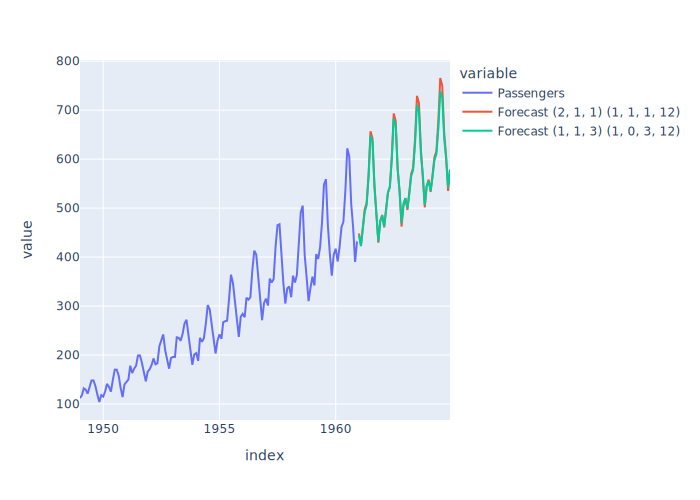